## Inicialização

### **Definir todos os pacotes a utilizar e a importar**

In [1]:
import os                                              # Operating System
import gc                                              # Garbage Collector
import re                                              # Regular Expression

import cv2                                             # OpenCV
import math                                            # Fuções Matemáticas
import numpy as np                                     # Computação Científica
import scipy as sp                                     # Análise de Dados
import pandas as pd                                    # Análise de Dados

import tensorflow as tf                                # Tensorflow - API Machine Learning
from IPython.display import SVG                        # Scalable Vector Graphics
from keras.utils import model_to_dot                   # Converte o modelo usado em modelo de pontos
from keras.utils import plot_model                     # Igual ao model_to_dot, mas escreve para um ficheiro
import tensorflow.keras.layers as L                    # Camadas Keras - Usado para fazer Pooling e Dense, no modelo.
from tensorflow.keras.models import Model              # Utilizado para a definição do modelo utilizado na rede neuronal
from tensorflow.keras.applications import DenseNet121  # DenseNet121 - arquitetura

from kaggle_datasets import KaggleDatasets             # Datasets da plataforma Kaggle

from tqdm import tqdm                                  # Barra de progressão
from sklearn import metrics                            # Dá métricas para os outputs da rede neuronal
from sklearn.utils import shuffle                      # Rearranja os arrays de forma consistente
from sklearn.model_selection import train_test_split   # Divide o array em grupo de treino e de teste
import matplotlib.pyplot as plt                        # Gráficos

import plotly.express as px                            # Gráficos
import plotly.graph_objects as go                      
import plotly.figure_factory as ff                     
from plotly.subplots import make_subplots              

tqdm.pandas()                                          # Barra de progressão no Pandas
np.random.seed(0)                                      # Faz com que números aleatórios sejam expectáveis
tf.random.set_seed(0)                                  # Faz com que números aleatórios sejam expectáveis

import warnings                                        # Ignorar avisos não importantes
warnings.filterwarnings("ignore")                      

/opt/conda/lib/python3.7/site-packages/tqdm/std.py:666: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


### **Carregar os dados e definir os parâmetros**

Nesta secção é realizada a atribuição de variáveis a caminhos de dados e a valores fixos para mais parte serem trabalhados. 

É feito ainda a leitura dos ficheiros excel, tanto do conjunto de treino como do conjunto de teste.

In [2]:
EPOCHS = 20       # Número de iterações do algoritmo
SAMPLE_LEN = 100  # Tamanho da amostra
IMAGE_PATH = "../input/plant-pathology-2020-fgvc7/images/"
TEST_PATH = "../input/plant-pathology-2020-fgvc7/test.csv"
TRAIN_PATH = "../input/plant-pathology-2020-fgvc7/train.csv"
SUB_PATH = "../input/plant-pathology-2020-fgvc7/sample_submission.csv"

sub = pd.read_csv(SUB_PATH)
test_data = pd.read_csv(TEST_PATH)
train_data = pd.read_csv(TRAIN_PATH)

In [3]:
# Leitura do cabeçalho do ficheiro de treino
train_data.head()

image_id  healthy  multiple_diseases  rust  scab
0  Train_0        0                  0     0     1
1  Train_1        0                  1     0     0
2  Train_2        1                  0     0     0
3  Train_3        0                  0     1     0
4  Train_4        1                  0     0     0

In [4]:
# Leitura do cabeçalho do ficheiro de teste
test_data.head()

image_id
0   Test_0
1   Test_1
2   Test_2
3   Test_3
4   Test_4

## Análise do dataset

### **Carregar as imagens de exemplo**

Esta célula é necessária para carregar imagens de exemplo para mais tarde serem também trabalhadas e submetidas a testes. Neste caso, são carregadas 100 imagens para serem submetidas a várias análises que mais à frente irão ser explicadas.

In [5]:
def load_image(image_id):
    file_path = image_id + ".jpg"
    image = cv2.imread(IMAGE_PATH + file_path)
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

train_images = train_data["image_id"][:SAMPLE_LEN].progress_apply(load_image)

100%|██████████| 100/100 [00:04<00:00, 21.84it/s]


### **Visualizar uma imagem**

In [6]:
fig = px.imshow(cv2.resize(train_images[0], (205,136)))
fig.show()

Esta é a primeira imagem do dataset, e os valores que aparecem ao colocar o cursor por cima da imagem representam os valores de x e y, e também os valores de RGB.

A imagem é ainda comprimida antes de ser apresentada, devido à alta dimensão do ficheiro.

Consegue-se observar que as partes mais saudáveis (verdes) apresentam valores muito baixos de azul, ao contrário das partes mais acastanhadas. Isto sugere que o canal da cor azul pode ter algum impacto na deteção de doenças nas plantas.

### **Distribuição dos canais das cores nas imagens**

In [7]:
red_values = [np.mean(train_images[id][:, :, 0]) for id in range(len(train_images))]
green_values = [np.mean(train_images[id][:, :, 1]) for id in range(len(train_images))]
blue_values = [np.mean(train_images[id][:, :, 2]) for id in range(len(train_images))]
values = [np.mean(train_images[id]) for id in range(len(train_images))]

In [8]:
fig = ff.create_distplot([red_values, green_values, blue_values],
                         group_labels=["R", "G", "B"],
                         colors=["red", "green", "blue"])
fig.update_layout(title_text="Distribuição das cores nas imagens", template="simple_white")
fig.data[0].marker.line.color = 'rgb(0, 0, 0)'
fig.data[0].marker.line.width = 0.5
fig.data[1].marker.line.color = 'rgb(0, 0, 0)'
fig.data[1].marker.line.width = 0.5
fig.data[2].marker.line.color = 'rgb(0, 0, 0)'
fig.data[2].marker.line.width = 0.5
fig

Neste gráfico consegue-se perceber que a cor verde é a mais presente, seguida do vermelho e do azul respetivamente.

### **Visualizar conjuntos de folhas de cada condição**

Nesta secção serão apresentadas 15 imagens aleatórias de cada conjunto de classificação:

In [9]:
def show_images(image_ids):
    
    col = 5
    row = min(len(image_ids) // col, 5)
    
    fig, ax = plt.subplots(row, col, figsize=(16, 8))
    ax = ax.flatten()

    for i, image_id in enumerate(image_ids):
        image = cv2.imread(IMAGE_PATH + '{}.jpg'.format(image_id))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        ax[i].set_axis_off()
        ax[i].imshow(image)
        ax[i].set_title(image_id)

#### **Folhas "Healthy"**

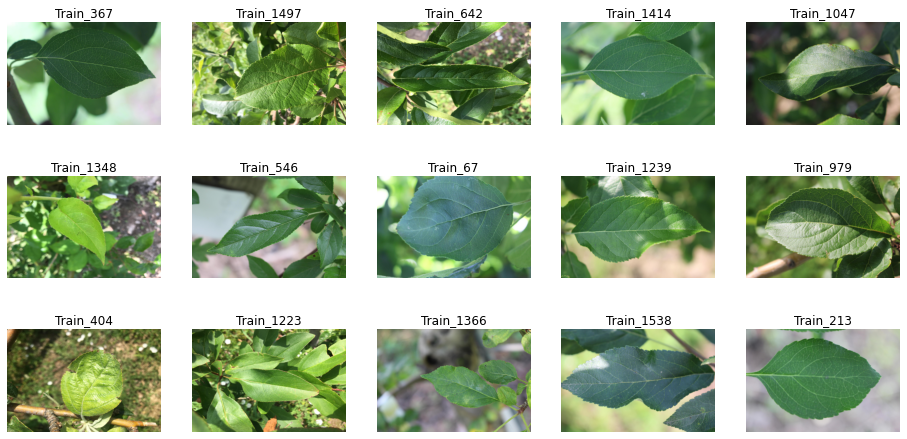

In [10]:
show_images(train_data[train_data['healthy'] == 1].sample(n=15)['image_id'].values)

#### **Folhas "Rust"**

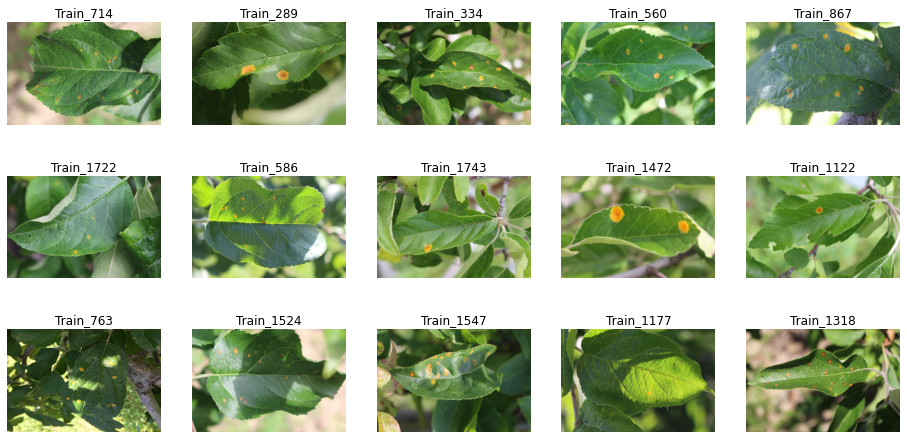

In [11]:
show_images(train_data[train_data['rust'] == 1].sample(n=15)['image_id'].values)

#### **Folhas "Scab"**

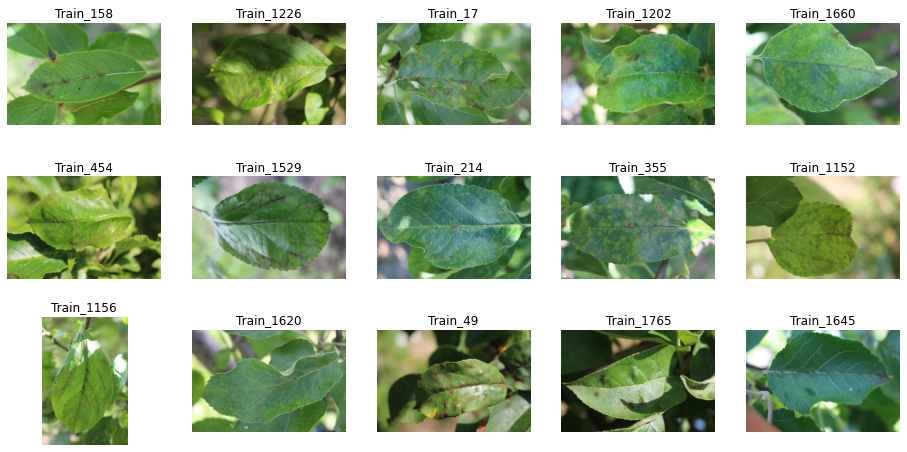

In [12]:
show_images(train_data[train_data['scab'] == 1].sample(n=15)['image_id'].values)

#### **Folhas "Multiple Diseases"**

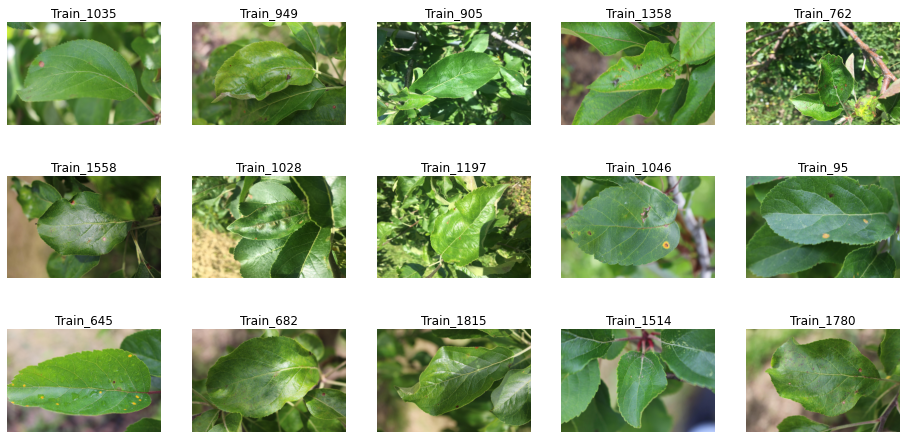

In [13]:
show_images(train_data[train_data['multiple_diseases'] == 1].sample(n=15)['image_id'].values)

### **Visualizar estatísticas dos tipos de folhas existentes**

In [14]:
fig = go.Figure([go.Pie(labels=train_data.columns[1:],
           values=train_data.iloc[:, 1:].sum().values)])
fig.update_layout(title_text="Gráfico dos objetivos", template="simple_white")
fig.data[0].marker.line.color = 'rgb(0, 0, 0)'
fig.data[0].marker.line.width = 0.5
fig.show()

Consegue-se observar, pelo gráfico acima, que da amostra total de 1821 imagens existe um maior número de folhas com características "rust" (ferrugem) e "scab" (crostas), e uma percentagem mínima de folhas com "multiple diseases" (doenças múltiplas). 

Cerca de 28% da amostra é representada por folhas saudáveis.

## **Aumento e Processamento de imagem**

De seguida irei apresentar algumas formas de processamento e aumento de imagem. Este tipo de processos são bastante úteis para reduzir o tempo de aprendizagem nas redes neuronais, uma vez que reduz o tamanho dos arquivos substancialmente e consegue apresentar os resultados que se pretende de forma mais fácil e objetiva.

Alguns dos exemplos apresentados de seguida não irão ser utilizados na rede neuronal definida para este problema, no entanto consegue-se ter uma ideia de cada processo, e o que é feito muita das vezes por trás de uma Rede Neuronal Convolucional.

### **Deteção de fronteiras - Canny**

Este é um famoso algoritmo de identificação de fronteiras. Tal como o nome indica, este algoritmo deteta as fronteiras dos objetos pretendidos na imagem através de alguns processos inerentes.

![](https://image.slidesharecdn.com/e2822eef-6993-4540-9321-65ca5f35eb39-161009120200/95/exploring-methods-to-improve-edge-detection-with-canny-algorithm-13-638.jpg?cb=1476014597)

O resultado é um mapa binário (0 ou 255), indicando a localização dos elementos pretendidos e das suas fronteiras na imagem.

Está demonstrado abaixo com um exemplo de uma imagem de uma folha do dataset.

In [15]:
def edge_and_cut(img):
    emb_img = img.copy()
    edges = cv2.Canny(img, 100, 200)
    edge_coors = []
    for i in range(edges.shape[0]):
        for j in range(edges.shape[1]):
            if edges[i][j] != 0:
                edge_coors.append((i, j))
    
    row_min = edge_coors[np.argsort([coor[0] for coor in edge_coors])[0]][0]
    row_max = edge_coors[np.argsort([coor[0] for coor in edge_coors])[-1]][0]
    col_min = edge_coors[np.argsort([coor[1] for coor in edge_coors])[0]][1]
    col_max = edge_coors[np.argsort([coor[1] for coor in edge_coors])[-1]][1]
    new_img = img[row_min:row_max, col_min:col_max]
    
    emb_img[row_min-10:row_min+10, col_min:col_max] = [255, 0, 0]
    emb_img[row_max-10:row_max+10, col_min:col_max] = [255, 0, 0]
    emb_img[row_min:row_max, col_min-10:col_min+10] = [255, 0, 0]
    emb_img[row_min:row_max, col_max-10:col_max+10] = [255, 0, 0]
    
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(30, 20))
    ax[0].imshow(img, cmap='gray')
    ax[0].set_title('Imagem Original', fontsize=24)
    ax[1].imshow(edges, cmap='gray')
    ax[1].set_title('Canny', fontsize=24)
    ax[2].imshow(emb_img, cmap='gray')
    ax[2].set_title('Fronteiras', fontsize=24)
    plt.show()

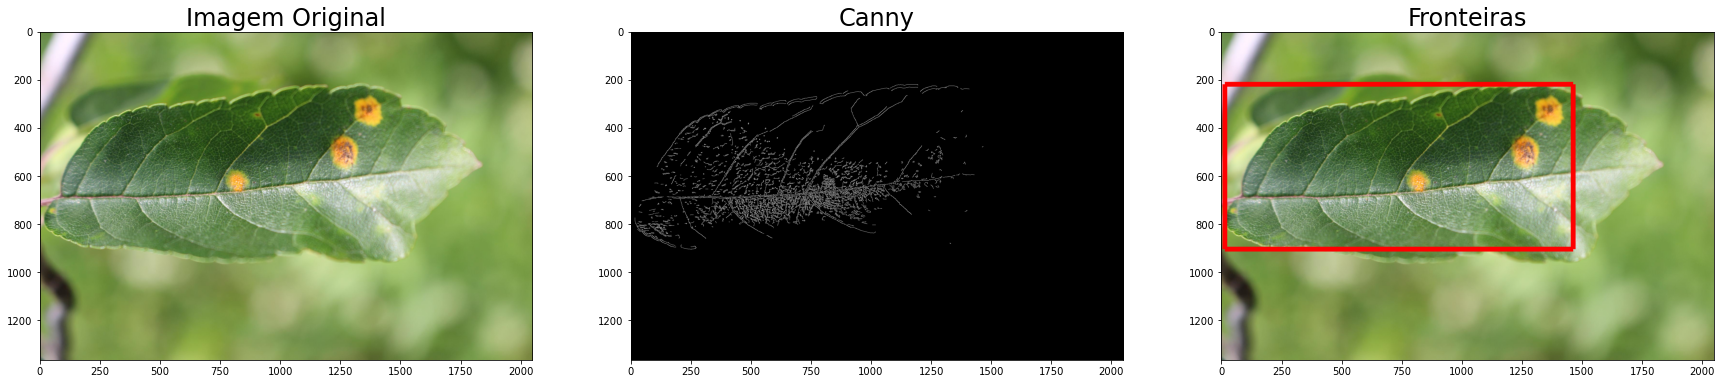

In [16]:
edge_and_cut(train_images[3])

A segunda coluna é representativa do algoritmo Canny, onde mostra todos os pontos que o algoritmo identifica como sendo parte do elemento procurado. A terceira coluna é uma representação das fronteiras, onde se consegue observar que existe sempre a maior parte da folha ou até a folha inteira dentro dos limites.

Este algoritmo é utilizado para construir modelos mais precisos.

### **Inverter**

Este algoritmo realiza a inversão da imagem tanto na vertical como na horizontal. 

Nas imagens abaixo, consegue-se ver a imagem original à esquerda, a imagem invertida na vertical ao centro e a imagem invertida na horizontal à direita.

Estas transformações podem ser usadas para construir modelos mais robustos e precisos.

In [17]:
def invert(img):
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(30, 20))
    ax[0].imshow(img)
    ax[0].set_title('Imagem Original', fontsize=24)
    ax[1].imshow(cv2.flip(img, 0))
    ax[1].set_title('Inversão Vertical', fontsize=24)
    ax[2].imshow(cv2.flip(img, 1))
    ax[2].set_title('Inversão Horizontal', fontsize=24)
    plt.show()

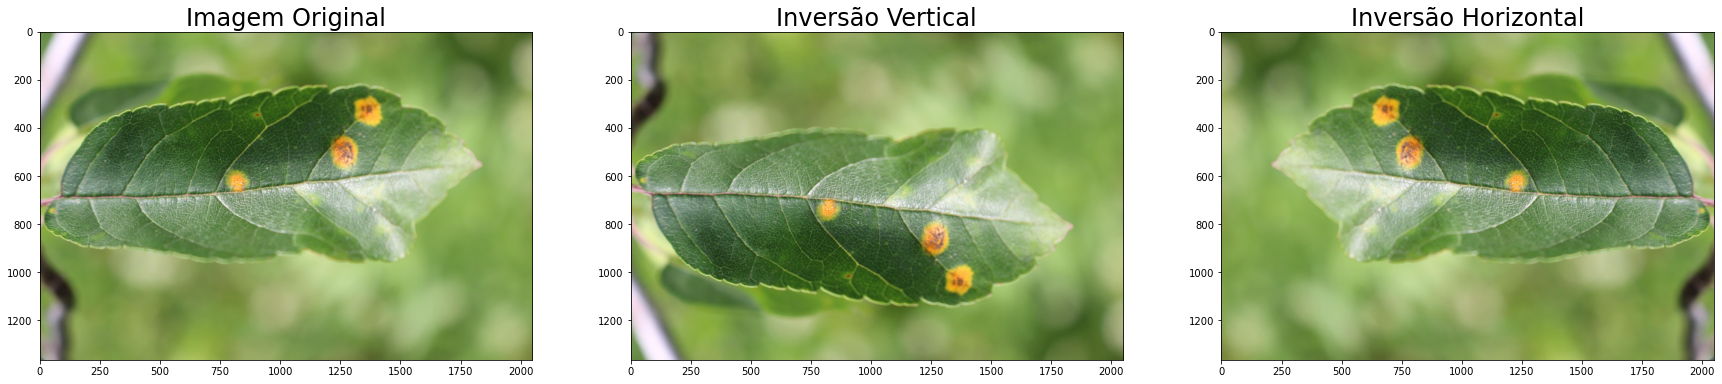

In [18]:
invert(train_images[3])

### **Convolução**

A convolução é um dos principais algoritmos em machine learning e em problemas de inteligência artifical que tenham por base a identificação de imagens.

O seu funcionamento consiste em fazer arrastar uma matriz 2D por cima da imagem, e calcular o seu produto ao longo do caminho. O gif abaixo demonstra o processo básico deste algoritmo:

![](https://media2.giphy.com/media/i4NjAwytgIRDW/200.gif)

O seu objetivo principal é conseguir encontrar características importantes da imagem, como fronteiras ou alterações de cores. 

Em termos de algoritmos mais avançados, como a função DenseNet121 utilizada neste notebook mais à frente, a convolução é utlilzada em vários níveis, onde por exemplo a primeira camada, camada de baixo nível, é responsável por fronteiras, cores, gradientes, e onde as camadas de alto nível se iram focar na rede neuronal que terá todo o entendimento das imagens do dataset.

Este algoritmo é bastante útil na medida em que consegue gerar modelos mais precisos e robubstos.

Abaixo está um exemplo deste algoritmo a ser utilizado numa imagem do dataset.

In [19]:
def conv(img):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 20))
    kernel = np.ones((7, 7), np.float32)/25
    conv = cv2.filter2D(img, -1, kernel)
    ax[0].imshow(img)
    ax[0].set_title('Imagem Original', fontsize=24)
    ax[1].imshow(conv)
    ax[1].set_title('Imagem Convolucional', fontsize=24)
    plt.show()

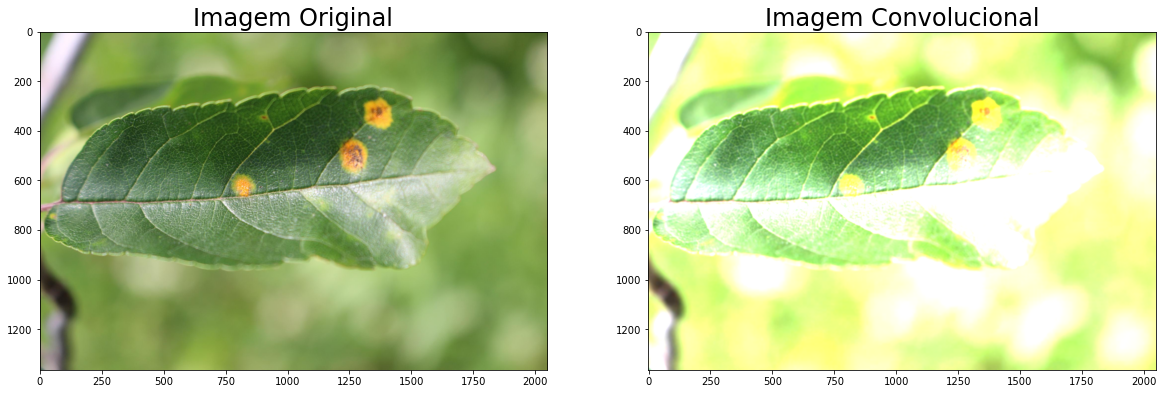

In [20]:
conv(train_images[3])

### **Desfoque**

Este tipo de processamento de imagem é apenas a adição de ruído a uma imagem. Deste modo consegue ofuscar os detalhes de baixo-nivel e salientar os detalhes de alto-nível.

Com este método, é mais uma vez, mais fácil de criar modelos mais precisos.

Abaixo está um exemplo de desfoque numa imagem do dataset deste desafio.

In [21]:
def blur(img):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 20))
    ax[0].imshow(img)
    ax[0].set_title('Imagem Original', fontsize=24)
    ax[1].imshow(cv2.blur(img, (100, 100)))
    ax[1].set_title('Imagem Desfocada', fontsize=24)
    plt.show()

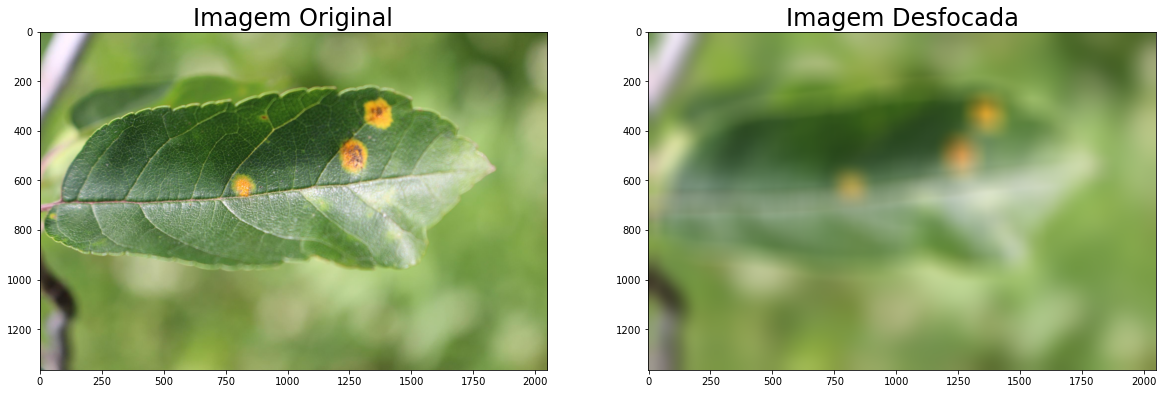

In [22]:
blur(train_images[3])

## **Pré-Definição do modelo**

Nesta secção será realizada uma pré-definição do modelo a utilizar, e definir os conjuntos de treino e de teste.


Primeiramente é definido o TPU (Tensor Processing Unit).

Os TPUs são aceleradores de hardware especializados para tarefas de deep learning. Estes estão suportados na plataforma Kaggle, tal como também na API tensorflow, apartir da versão 2.1.

In [23]:
AUTO = tf.data.experimental.AUTOTUNE
tpu = tf.distribute.cluster_resolver.TPUClusterResolver()

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
strategy = tf.distribute.experimental.TPUStrategy(tpu)

BATCH_SIZE = 16 * strategy.num_replicas_in_sync
GCS_DS_PATH = KaggleDatasets().get_gcs_path()

Esta próxima célula tem como objetivo definir o caminho para o dataset, e conseguir modelar os valores de forma a criar o modelo de treino e o modelo de teste.

É realizada ainda a definição da separação do modelo de teste e do modelo de treino.

In [24]:
def format_path(st):
    return GCS_DS_PATH + '/images/' + st + '.jpg'

test_paths = test_data.image_id.apply(format_path).values
train_paths = train_data.image_id.apply(format_path).values

train_labels = np.float32(train_data.loc[:, 'healthy':'scab'].values)
train_paths, valid_paths, train_labels, valid_labels =\
train_test_split(train_paths, train_labels, test_size=0.15, random_state=2020)

De seguida serão definidas funções de descodificação de imagens e de aumento de dados, de forma a que a rede neuronal consiga obter valores mais precisos para o dataset. 

Neste caso é redefinido a dimensão das imagens, e é feito as rotações das mesmas para obter resultados mais significativos.

In [25]:
def decode_image(filename, label=None, image_size=(512, 512)):
    bits = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(bits, channels=3)
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.image.resize(image, image_size)
    
    if label is None:
        return image
    else:
        return image, label

def data_augment(image, label=None):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    
    if label is None:
        return image
    else:
        return image, label

Nesta próxima célula são então definidos os conjuntos de treino, de validação e de teste, respetivamente:

In [26]:
train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((train_paths, train_labels))
    .map(decode_image, num_parallel_calls=AUTO)
    .map(data_augment, num_parallel_calls=AUTO)
    .repeat()
    .shuffle(512)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

valid_dataset = (
    tf.data.Dataset
    .from_tensor_slices((valid_paths, valid_labels))
    .map(decode_image, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .cache()
    .prefetch(AUTO)
)

test_dataset = (
    tf.data.Dataset
    .from_tensor_slices(test_paths)
    .map(decode_image, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
)

Antes de avançar para o modelo é ainda definido a taxa de aprendizagem da rede neuronal (Learning Rate). Este irá ser dinâmico em função de cada iteração.

In [27]:
def build_lrfn(lr_start=0.00001, lr_max=0.00005, 
               lr_min=0.00001, lr_rampup_epochs=5, 
               lr_sustain_epochs=0, lr_exp_decay=.8):
    lr_max = lr_max * strategy.num_replicas_in_sync

    def lrfn(epoch):
        if epoch < lr_rampup_epochs:
            lr = (lr_max - lr_start) / lr_rampup_epochs * epoch + lr_start
        elif epoch < lr_rampup_epochs + lr_sustain_epochs:
            lr = lr_max
        else:
            lr = (lr_max - lr_min) *\
                 lr_exp_decay**(epoch - lr_rampup_epochs\
                                - lr_sustain_epochs) + lr_min
        return lr
    return lrfn

In [28]:
lrfn = build_lrfn()
STEPS_PER_EPOCH = train_labels.shape[0] // BATCH_SIZE
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=1)

## **Criação do modelo**

### **DenseNet121**

Na definição da rede neuronal é utilizado o atributo Sequential(), de forma a conseguir criar uma rede com várias camadas. 

Neste caso, a primeira camada é a chamada da arquitetura DenseNet121. Esta arquitetura tem por base a ImageNet, que é uma base de dados de imagens, em que já tem os pesos com base num pré treino desta plataforma, de forma a conseguir obter o melhor output possível em termos de precisão e de resultados. Obtendo uma taxa de erro mínima.

De seguida é então chamada a convuloção existente na biblioteca Tensorflow, para aplicar a convolução às imagens. E de seguida é criada a rede neuronal com o método Dense(), com a função de ativação SoftMax, uma função sigmóide.



In [29]:
with strategy.scope():
    # Definição do modelo (DenseNet121)
    model = tf.keras.Sequential([DenseNet121(input_shape=(512, 512, 3),
                                             weights='imagenet',
                                             include_top=False),
                                 L.GlobalAveragePooling2D(), # Convolução
                                 L.Dense(train_labels.shape[1],
                                         activation='softmax')]) # Softmax como função de ativação
    
    # Configuração das métricas e do erro
    model.compile(optimizer='adam',
                  loss = 'categorical_crossentropy',
                  metrics=['categorical_accuracy'])
    model.summary()

29089792/29084464 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Model)          (None, 16, 16, 1024)      7037504   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 4)                 4100      
Total params: 7,041,604
Trainable params: 6,957,956
Non-trainable params: 83,648
_________________________________________________________________


Este output mostra assim as várias camadas feitas, e a forma de cada atributo. Mostra ainda também o número de parametros em cada camada que vão ser treinados.

In [30]:
# Treino da rede neuronal
history = model.fit(train_dataset,
                    epochs=EPOCHS,
                    callbacks=[lr_schedule],
                    steps_per_epoch=STEPS_PER_EPOCH,
                    validation_data=valid_dataset)


Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
Epoch 1/20
12/12 [==============================] - 66s 6s/step - categorical_accuracy: 0.2786 - loss: 1.5491 - val_categorical_accuracy: 0.2555 - val_loss: 1.4343 - lr: 1.0000e-05

Epoch 00002: LearningRateScheduler reducing learning rate to 8.8e-05.
Epoch 2/20
12/12 [==============================] - 15s 1s/step - categorical_accuracy: 0.6595 - loss: 0.8995 - val_categorical_accuracy: 0.4234 - val_loss: 1.1967 - lr: 8.8000e-05

Epoch 00003: LearningRateScheduler reducing learning rate to 0.000166.
Epoch 3/20
12/12 [==============================] - 32s 3s/step - categorical_accuracy: 0.8704 - loss: 0.3891 - val_categorical_accuracy: 0.5073 - val_loss: 1.3201 - lr: 1.6600e-04

Epoch 00004: LearningRateScheduler reducing learning rate to 0.000244.
Epoch 4/20
12/12 [==============================] - 31s 3s/step - categorical_accuracy: 0.9382 - loss: 0.1927 - val_categorical_accuracy: 0.6569 - val_loss: 1.0117 - lr: 2.4

Este output mostra os 20 Epochs (iterações) que foram definidos inicialmente no notebook, e em cada iteração mostra também o Learning Rate, variando em cada um. E mostra também a precisão e o erro de cada iteração para o conjunto de validação e para o conjunto de treino.

## Resultados

In [31]:
def display_training_curves(training, validation, yaxis):
    if yaxis == "loss":
        ylabel = "Erro"
        title = "Erro vs. Epochs"
    else:
        ylabel = "Precisão"
        title = "Precisão vs. Epochs"
        
    fig = go.Figure()
        
    fig.add_trace(
        go.Scatter(x=np.arange(1, EPOCHS+1), mode='lines+markers', y=training, marker=dict(color="dodgerblue"),
               name="Treino"))
    
    fig.add_trace(
        go.Scatter(x=np.arange(1, EPOCHS+1), mode='lines+markers', y=validation, marker=dict(color="darkorange"),
               name="Validação"))
    
    fig.update_layout(title_text=title, yaxis_title=ylabel, xaxis_title="Epochs", template="plotly_white")
    fig.show()

In [32]:
display_training_curves(
    history.history['categorical_accuracy'], 
    history.history['val_categorical_accuracy'], 
    'accuracy')

No gráfico acima, observa-se a evolução da precisão da rede neuronal ao longo das várias iterações, aproximando-se muito rapidamente do valor de 1, valor ótimo para uma rede neuronal, que significa que não existe erro na decisão.

Como se pode ver, no conjunto de validação, existem valores de precisão de 0,99, aproximadamente.

No conjunto de validação, existem valores máximos de 0,94, o que represetnam valores muito bons para este tipo de problema. Significa que 94% das vezes irá obter-se valores corretos na decisão da doença da folha.

De seguida são mostrados alguns exemplos de imagens e qual a decisão da rede neuronal para cada uma. Neste caso é mostrado em forma de gráfico a probabilidade de pertencer a determinado atributo (Healthy, Rust, Scab, Multiple Diseases).

In [33]:
def process(img):
    return cv2.resize(img/255.0, (512, 512)).reshape(-1, 512, 512, 3)
def predict(img):
    return model.layers[2](model.layers[1](model.layers[0](process(img)))).numpy()[0]

fig = make_subplots(rows=4, cols=2)
preds = predict(train_images[2])

colors = {"Healthy":px.colors.qualitative.Plotly[0], "Scab":px.colors.qualitative.Plotly[0], "Rust":px.colors.qualitative.Plotly[0], "Multiple diseases":px.colors.qualitative.Plotly[0]}
if list.index(preds.tolist(), max(preds)) == 0:
    pred = "Healthy"
if list.index(preds.tolist(), max(preds)) == 1:
    pred = "Scab"
if list.index(preds.tolist(), max(preds)) == 2:
    pred = "Rust"
if list.index(preds.tolist(), max(preds)) == 3:
    pred = "Multiple diseases"

colors[pred] = px.colors.qualitative.Plotly[1]
colors["Healthy"] = "seagreen"
colors = [colors[val] for val in colors.keys()]
fig.add_trace(go.Image(z=cv2.resize(train_images[2], (205, 136))), row=1, col=1)
fig.add_trace(go.Bar(x=["Healthy", "Multiple diseases", "Rust", "Scab"], y=preds, marker=dict(color=colors)), row=1, col=2)
fig.update_layout(height=1200, width=800, title_text="Outputs da DenseNet", showlegend=False)

preds = predict(train_images[0])
colors = {"Healthy":px.colors.qualitative.Plotly[0], "Scab":px.colors.qualitative.Plotly[0], "Rust":px.colors.qualitative.Plotly[0], "Multiple diseases":px.colors.qualitative.Plotly[0]}
if list.index(preds.tolist(), max(preds)) == 0:
    pred = "Healthy"
if list.index(preds.tolist(), max(preds)) == 1:
    pred = "Multiple diseases"
if list.index(preds.tolist(), max(preds)) == 2:
    pred = "Rust"
if list.index(preds.tolist(), max(preds)) == 3:
    pred = "Scab"
    
colors[pred] = px.colors.qualitative.Plotly[1]
colors["Multiple diseases"] = "seagreen"
colors = [colors[val] for val in colors.keys()]
fig.add_trace(go.Image(z=cv2.resize(train_images[0], (205, 136))), row=2, col=1)
fig.add_trace(go.Bar(x=["Healthy", "Multiple diseases", "Rust", "Scab"], y=preds, marker=dict(color=colors)), row=2, col=2)

preds = predict(train_images[3])
colors = {"Healthy":px.colors.qualitative.Plotly[0], "Scab":px.colors.qualitative.Plotly[0], "Rust":px.colors.qualitative.Plotly[0], "Multiple diseases":px.colors.qualitative.Plotly[0]}
if list.index(preds.tolist(), max(preds)) == 0:
    pred = "Healthy"
if list.index(preds.tolist(), max(preds)) == 1:
    pred = "Multiple diseases"
if list.index(preds.tolist(), max(preds)) == 2:
    pred = "Rust"
if list.index(preds.tolist(), max(preds)) == 3:
    pred = "Scab"
    
colors[pred] = px.colors.qualitative.Plotly[1]
colors["Rust"] = "seagreen"
colors = [colors[val] for val in colors.keys()]
fig.add_trace(go.Image(z=cv2.resize(train_images[3], (205, 136))), row=3, col=1)
fig.add_trace(go.Bar(x=["Healthy", "Multiple diseases", "Rust", "Scab"], y=preds, marker=dict(color=colors)), row=3, col=2)

preds = predict(train_images[1])
colors = {"Healthy":px.colors.qualitative.Plotly[0], "Scab":px.colors.qualitative.Plotly[0], "Rust":px.colors.qualitative.Plotly[0], "Multiple diseases":px.colors.qualitative.Plotly[0]}
if list.index(preds.tolist(), max(preds)) == 0:
    pred = "Healthy"
if list.index(preds.tolist(), max(preds)) == 1:
    pred = "Multiple diseases"
if list.index(preds.tolist(), max(preds)) == 2:
    pred = "Rust"
if list.index(preds.tolist(), max(preds)) == 3:
    pred = "Scab"
    
colors[pred] = px.colors.qualitative.Plotly[1]
colors["Scab"] = "seagreen"
colors = [colors[val] for val in colors.keys()]
fig.add_trace(go.Image(z=cv2.resize(train_images[1], (205, 136))), row=4, col=1)
fig.add_trace(go.Bar(x=["Healthy", "Multiple diseases", "Rust", "Scab"], y=preds, marker=dict(color=colors)), row=4, col=2)

fig.update_layout(template="plotly_white")

Esta última célula escreve todos os valores das probabilidades de cada folha obtidos pela rede neuronal, para um ficheiro csv.

In [34]:
probs_dnn = model.predict(test_dataset, verbose=1)
sub.loc[:, 'healthy':] = probs_dnn
sub.to_csv('results_cnn.csv', index=False)
sub.head()

15/15 [==============================] - 51s 3s/step


image_id   healthy  multiple_diseases      rust      scab
0   Test_0  0.000112           0.003262  0.996598  0.000029
1   Test_1  0.003146           0.024062  0.972512  0.000279
2   Test_2  0.000039           0.000054  0.000008  0.999899
3   Test_3  0.999944           0.000010  0.000039  0.000007
4   Test_4  0.000008           0.001906  0.998037  0.000049